In [17]:
import time
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from osmnx import project_gdf

In [2]:
geocoded_gdf = gpd.read_file('outputs/geocoded_df.geojson')

In [3]:
geocoded_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 161327 entries, 0 to 161326
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   place_id      102114 non-null  float64 
 1   licence       102114 non-null  object  
 2   osm_type      102114 non-null  object  
 3   osm_id        102114 non-null  float64 
 4   lat           102114 non-null  object  
 5   lon           102114 non-null  object  
 6   display_name  102114 non-null  object  
 7   class         102114 non-null  object  
 8   type          102114 non-null  object  
 9   importance    102114 non-null  float64 
 10  geometry      102114 non-null  geometry
dtypes: float64(3), geometry(1), object(7)
memory usage: 13.5+ MB


In [5]:
ccpp_osiptel = gpd.read_file('inputs/cp_osiptel')

In [6]:
ccpp_osiptel.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Name        1171 non-null   object  
 1   descriptio  0 non-null      object  
 2   timestamp   0 non-null      object  
 3   begin       0 non-null      object  
 4   end         0 non-null      object  
 5   altitudeMo  0 non-null      object  
 6   tessellate  1171 non-null   int64   
 7   extrude     1171 non-null   int64   
 8   visibility  1171 non-null   int64   
 9   drawOrder   0 non-null      object  
 10  icon        0 non-null      object  
 11  layer       1171 non-null   object  
 12  path        1171 non-null   object  
 13  geometry    1171 non-null   geometry
dtypes: geometry(1), int64(3), object(10)
memory usage: 128.2+ KB


In [9]:
geocoded_gdf_proj = project_gdf(geocoded_gdf)
ccpp_osiptel_proj = project_gdf(ccpp_osiptel)
print('have same proj:', geocoded_gdf_proj.crs == ccpp_osiptel_proj.crs)

have same proj: True


In [10]:
print('Assign polygon to points observations (Spatial Join - nearest)')
start = time.time()
geocoded_gdf_nearest_ccpp = geocoded_gdf_proj.sjoin_nearest(
    right=ccpp_osiptel_proj[['Name','geometry']],
    how='inner',
    distance_col='distance_to_cp',
)
print('Elapsed time:', round(time.time() - start,2), 'seconds')

Assign polygon to points observations (Spatil Join - nearest)
Elapsed time: 16.8 seconds


In [11]:
geocoded_gdf.dropna(subset='geometry').shape, geocoded_gdf_nearest_ccpp.shape

((102114, 11), (102123, 14))

In [12]:
duplicates_bool = geocoded_gdf_nearest_ccpp.index.duplicated()
duplicates_ixs = geocoded_gdf_nearest_ccpp.index[duplicates_bool]

In [13]:
len(duplicates_ixs.unique())

9

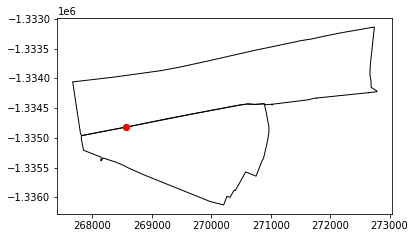

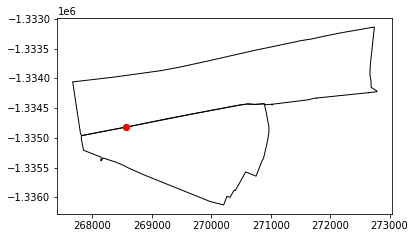

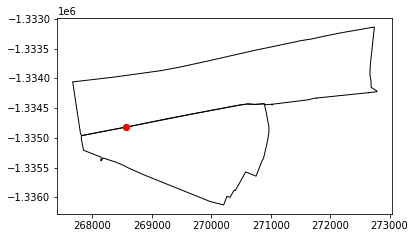

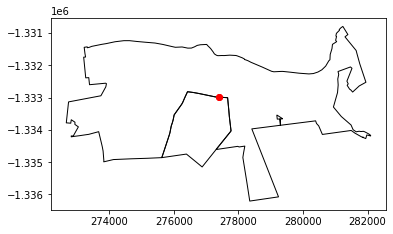

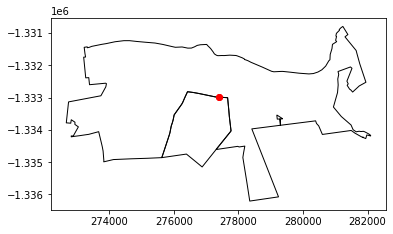

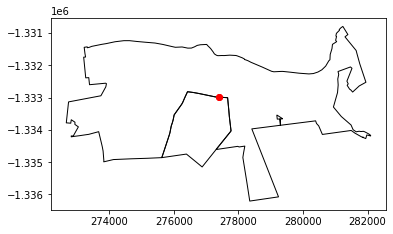

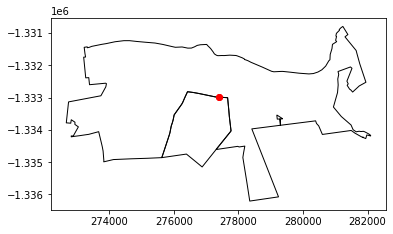

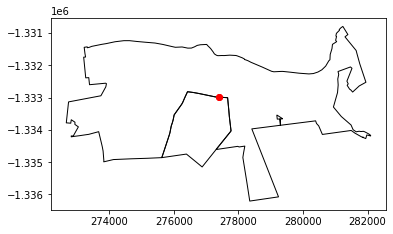

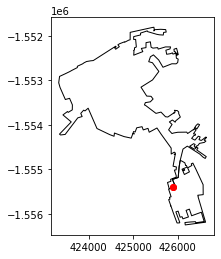

In [18]:
for ixs in duplicates_ixs: 
    rows = geocoded_gdf_nearest_ccpp.loc[ixs]
    ax = ccpp_osiptel_proj[ccpp_osiptel_proj['Name'].isin(rows['Name'].values)].plot(
        edgecolor='k',
        facecolor='none'
    )
    rows.plot(ax=ax, color='r')
    plt.show()

### Check distances greater than 0

In [20]:
distance_to_cp = geocoded_gdf_nearest_ccpp[geocoded_gdf_nearest_ccpp['distance_to_cp']>0]['distance_to_cp']

In [21]:
distance_to_cp.shape

(2181,)

In [22]:
distance_to_cp.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]).round(2)

count     2181.00
mean      6293.43
std       7365.34
min          0.01
10%          1.51
20%        168.89
30%       1199.17
40%       1688.85
50%       3420.45
60%       6730.68
70%       8377.50
80%      10707.98
90%      15376.25
max      52141.17
Name: distance_to_cp, dtype: float64

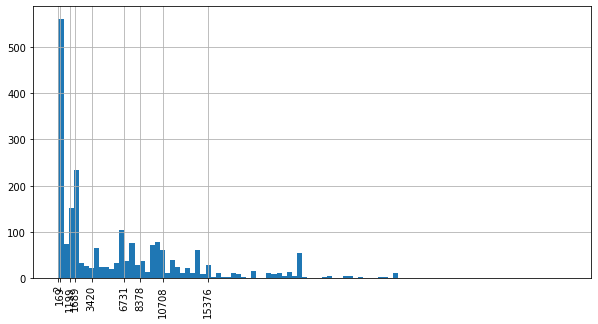

In [26]:
distance_to_cp.hist(bins=100, figsize=(10,5))
plt.xticks(distance_to_cp.quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9]).round(2).values, rotation=90)
plt.show()

In [24]:
# Points at a distances greater than 1km
(distance_to_cp > 1000).sum(), (distance_to_cp > 1000).sum() / distance_to_cp.shape[0] * 100

(1547, 70.9307657038056)

In [25]:
# Points at a distances greater than 1km
(distance_to_cp > 2000).sum(), (distance_to_cp > 2000).sum() / distance_to_cp.shape[0] * 100

(1169, 53.5992663915635)

In [28]:
geocoded_gdf_nearest_ccpp.to_file("geocoded_df_ccpp.geojson", driver="GeoJSON")

/Users/claudio/.pyenv/versions/peru-connect-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
